# 2nd trial model LeNet on the COVID-19 CXR images dataset
In this notebook, we concider data arrengement in the 3 groups directly (no Train, test, val yet).
We'll fisrt tune our LeNet model with keras-tuner on some data pictures (1100) and then train and evaluate it on data.
Next will train LeNet model with DtaScientest Notebook training parameters and  compare results.

## 1- Data preparation
Loading data from directory, ensuring shape of feature, put in array and creat target data/

In [16]:
import numpy as np
import pandas as pd
import cv2

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os


In [17]:
base_path = r'C:\Users\tomba\Documents\GitHub\MAR24_BDS_Radios_Pulmonaire\data\processed\Lung Segmentation Data'

In [18]:
# Function to read image as array
def images_to_array(directory, stop_crit):
    image_list = []
    init_crit = 0
    for filename in tqdm(os.listdir(directory)):
        if (filename.endswith(".jpg") or filename.endswith(".png")) and (init_crit < stop_crit): 
            img = cv2.imread(os.path.join(directory, filename),  cv2.IMREAD_GRAYSCALE)
            #img_resized = cv2.resize(img, target_shape)
            img_array = np.array(img)
            image_list.append(img_array)
            init_crit += 1
    final_array = np.concatenate(image_list, axis=0)
    
    return final_array

In [19]:
# Selection of data for modeling - target creation
features = []
targets = []
for group in os.listdir(base_path):
    img_mask_dir = os.path.join(base_path, group, 'images')
    features.append(images_to_array(img_mask_dir, 1100))
    group_label = np.array([group]*1100)  # Creating target labels
    targets.append(group_label)
    

features = np.concatenate(features, axis=0)
targets = np.concatenate(targets, axis=0)
features = features.reshape((-1, 256, 256, 1))

    

  0%|          | 0/11956 [00:00<?, ?it/s]

100%|██████████| 10701/10701 [00:00<00:00, 12240.17it/s]


In [20]:
label_encoder = LabelEncoder()
targets_encoded = label_encoder.fit_transform(targets)

In [21]:
print("Features shape:", features.shape)
print("Targets encoded shape:", targets_encoded.shape)

Features shape: (3300, 256, 256, 1)
Targets encoded shape: (3300,)


Text(0.5, 1.0, 'COVID-19 -> 0')

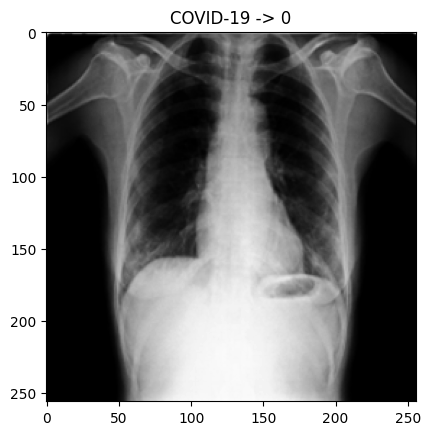

In [22]:
rd_masked_image =np.random.choice(len(features))
plt.imshow(features[rd_masked_image], cmap='gray')
plt.title(targets[rd_masked_image] +' -> ' + str(targets_encoded[rd_masked_image]))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(features, targets_encoded, test_size=0.2, shuffle=True)
del features, targets_encoded, targets

In [24]:
from sklearn.preprocessing import OneHotEncoder
# Step 1: Reshape the target variable to a column vector
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Step 2: One-Hot Encoding
encoder = OneHotEncoder(categories='auto')
y_train = encoder.fit_transform(y_train).toarray()
y_test = encoder.fit_transform(y_test).toarray()

X_train = X_train/255
X_test = X_test/255

In [25]:
all_val_accuracy = [] #init
all_train_accuracy = []

# 2- Keras tuning on LeNet

In [26]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from sklearn import metrics


In [27]:
from tensorflow import keras
from keras_tuner import HyperModel, RandomSearch, HyperParameters
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    inputs = Input(shape=(256, 256, 1), name="Input")
    
    # First conv layer
    hp_filters1 = hp.Int('filters_1', min_value=16, max_value=64, step=16)
    conv_1 = Conv2D(filters=hp_filters1, kernel_size=(5, 5), padding='valid', activation='relu')(inputs)
    max_pool_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
    
    # Second conv layer
    hp_filters2 = hp.Int('filters_2', min_value=16, max_value=64, step=16)
    conv_2 = Conv2D(filters=hp_filters2, kernel_size=(3, 3), padding='valid', activation='relu')(max_pool_1)
    max_pool_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)

    flatten = Flatten()(max_pool_2)
    
    # Dropout
    hp_dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    dropout = Dropout(rate=hp_dropout_rate)(flatten)

    # Dense layer
    hp_units = hp.Int('units', min_value=64, max_value=256, step=64)
    dense_1 = Dense(units=hp_units, activation='relu')(dropout)
    outputs = Dense(units=3, activation='softmax')(dense_1)

    model = Model(inputs=inputs, outputs=outputs)
    
    # Define the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Compile the model with the selected optimizer and learning rate
    optimizer = Adam(learning_rate=hp_learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model


In [28]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=1,
    directory='model_tuning',
    project_name='Lenet_tuning'
)

tuner.search_space_summary()

Search space summary
Default search space size: 5
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
filters_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [29]:
tuner.search(X_train, y_train,
             epochs=10,  # You may adjust this
             validation_split=0.2)  # Or use validation_data if you have a separate validation set

Trial 15 Complete [00h 17m 05s]
val_accuracy: 0.8787878751754761

Best val_accuracy So Far: 0.8787878751754761
Total elapsed time: 02h 46m 36s


In [30]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of filters in the first conv layer is {best_hps.get('filters_1')}.
The optimal number of filters in the second conv layer is {best_hps.get('filters_2')}.
The optimal dropout rate is {best_hps.get('dropout_rate')}.
The optimal number of units in the dense layer is {best_hps.get('units')}.
""")

# Build the model with the optimal hyperparameters and train it
best_Lenet_model = tuner.get_best_models(num_models=1)[0]


The optimal number of filters in the first conv layer is 48.
The optimal number of filters in the second conv layer is 16.
The optimal dropout rate is 0.30000000000000004.
The optimal number of units in the dense layer is 64.



c:\Users\tomba\Documents\GitHub\COVID-QU-Ex-Dataset_analysis\myenv_project\lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [31]:
best_Lenet_model.compile(
    loss='categorical_crossentropy',  # Loss function
    optimizer='adam',                 # Optimizer
    metrics=['accuracy']              # Metric to monitor
)

# Step 2: Train the best model
training_history_best_model = best_Lenet_model.fit(
    X_train, y_train,                 # Training data and labels
    validation_split=0.2,             # Using 20% of the data for validation
    epochs=16,                        # Number of epochs for training
    batch_size=200                    # Batch size for the training
)

# Optionally, evaluate the model performance on unseen data
# test_loss, test_acc = best_model.evaluate(X_test, y_test)

# Step 3: Use the trained model for predictions or further analysis
# predictions = best_model.predict(X_new)


Epoch 1/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step - accuracy: 0.5803 - loss: 2.0615 - val_accuracy: 0.6705 - val_loss: 0.9362
Epoch 2/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.6899 - loss: 0.8713 - val_accuracy: 0.7462 - val_loss: 0.7431
Epoch 3/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.7491 - loss: 0.6658 - val_accuracy: 0.8030 - val_loss: 0.5853
Epoch 4/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.8145 - loss: 0.5229 - val_accuracy: 0.7443 - val_loss: 0.6475
Epoch 5/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.8110 - loss: 0.4956 - val_accuracy: 0.8068 - val_loss: 0.4959
Epoch 6/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.8588 - loss: 0.4106 - val_accuracy: 0.8277 - val_loss: 0.4593
Epoch 7/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.8660 - loss: 0.3787 - val_accuracy: 0.8466 - val_loss: 0.4244
Epoch 8/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.8684 - loss: 0.3546 - val_accuracy: 0.8258 - val_loss:

In [32]:
all_train_accuracy.append(training_history_best_model.history['accuracy'])
all_val_accuracy.append(training_history_best_model.history['val_accuracy'])

# 3-Without Kerax tuning
Hyperparameters from DataScientest learning notebook

## Images data NOT normalized
Scaled (/255) but not normalized


In [33]:
# Architecture du modèle
inputs=Input(shape = (256, 256,1), name = "Input")


conv_1 = Conv2D(filters = 30,                     # Nombre de filtres
                kernel_size = (5, 5),            # Dimensions du noyau
                padding = 'valid',               # Mode de Dépassement
                input_shape = (256, 256, 1),       # Dimensions de l'image en entrée
                activation = 'relu')             # Fonction d'activation

max_pool_1 = MaxPooling2D(pool_size = (2, 2))

conv_2 = Conv2D(filters = 16,                    
                kernel_size = (3, 3),          
                padding = 'valid',             
                activation = 'relu')

max_pool_2 = MaxPooling2D(pool_size = (2, 2))

flatten = Flatten()

dropout = Dropout(rate = 0.2)

dense_1 = Dense(units = 128,
                activation = 'relu')

dense_2 = Dense(units = 3,
                activation = 'softmax')
x=conv_1(inputs)
x=max_pool_1(x)
x=conv_2(x)
x=max_pool_2(x)


x=dropout(x)
x=flatten(x)
x=dense_1(x)
outputs=dense_2(x)




c:\Users\tomba\Documents\GitHub\COVID-QU-Ex-Dataset_analysis\myenv_project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [34]:
lenet = Model(inputs = inputs, outputs = outputs)

# Compilation
lenet.compile(loss='categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation
training_history_lenet = lenet.fit(X_train, y_train,          # données
                                   validation_split = 0.2,    # split de test
                                   epochs = 16,               # nombre d'epochs
                                   batch_size = 200)          # taille des batchs



Epoch 1/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.4096 - loss: 1.0994 - val_accuracy: 0.7197 - val_loss: 0.6458
Epoch 2/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.7652 - loss: 0.5845 - val_accuracy: 0.8106 - val_loss: 0.5011
Epoch 3/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.8271 - loss: 0.4839 - val_accuracy: 0.8314 - val_loss: 0.4567
Epoch 4/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.8630 - loss: 0.3905 - val_accuracy: 0.8504 - val_loss: 0.4262
Epoch 5/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.8665 - loss: 0.3854 - val_accuracy: 0.8580 - val_loss: 0.4063
Epoch 6/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.9008 - loss: 0.3016 - val_accuracy: 0.8693 - val_loss: 0.3870
Epoch 7/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.9178 - loss: 0.2647 - val_accuracy: 0.8504 - val_loss: 0.4070
Epoch 8/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.9133 - loss: 0.2534 - val_accuracy: 0.8542 - val_loss:

In [35]:
all_train_accuracy.append(training_history_lenet.history['accuracy'])
all_val_accuracy.append(training_history_lenet.history['val_accuracy'])


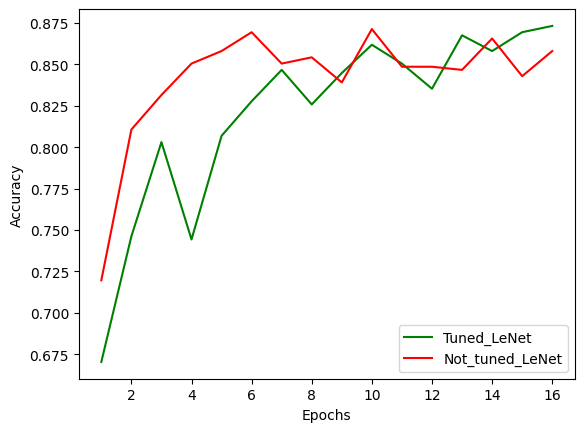

In [36]:
# Results
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(np.arange(1 , 17, 1),
         all_val_accuracy[0], 
         label = 'Tuned_LeNet',
         color = 'green')
plt.plot(np.arange(1 , 17, 1),
         all_val_accuracy[1], 
         label = 'Not_tuned_LeNet',
         color = 'red')         

plt.legend()


In [37]:
test_pred_lenet_T = best_Lenet_model.predict(X_test)
test_pred_lenet_class_T = test_pred_lenet_T.argmax(axis = 1)
y_test_class = y_test.argmax(axis = 1)

print(metrics.classification_report(y_test_class, test_pred_lenet_class_T))
pd.crosstab(y_test_class, test_pred_lenet_class_T)

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       217
           1       1.00      0.86      0.93       222
           2       0.79      0.92      0.85       221

    accuracy                           0.88       660
   macro avg       0.89      0.88      0.88       660
weighted avg       0.89      0.88      0.88       660



col_0,0,1,2
row_0,,,
0,184,0,33
1,9,192,21
2,18,0,203


In [38]:
test_pred_lenet = lenet.predict(X_test)
test_pred_lenet_class = test_pred_lenet.argmax(axis = 1)

print(metrics.classification_report(y_test_class, test_pred_lenet_class))
pd.crosstab(y_test_class, test_pred_lenet_class)

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       217
           1       0.95      0.87      0.91       222
           2       0.80      0.91      0.85       221

    accuracy                           0.87       660
   macro avg       0.88      0.87      0.87       660
weighted avg       0.88      0.87      0.87       660



col_0,0,1,2
row_0,,,
0,179,6,32
1,9,194,19
2,16,4,201
